In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

%matplotlib inline
sns.set()

zip_file = None
#indicateur du nombre de la population entre 15 et 64 ans
population_indicator_name = 'Population, ages 15-64, total'
#indicateur du nombre de la population inscrite en études post bac
tertiary_indicator_name = 'Enrolment in tertiary education, all programmes, both sexes (number)'
#indicateur du nombre de la population inscrite au lycée
secondary_indicator_name = 'Enrolment in secondary education, both sexes (number)'
#indicateur sur le pourcent d'utilisateurs internet
internet_indicator_name = 'Internet users (per 100 people)'
#indicateur pour le PIB par habitant
gdp_indicator_name = 'GDP per capita, PPP (current international $)'


def get_remote_zip_file():
    '''
       Initialization du fichier zip contenant toutes les données éducatives
    '''
    global zip_file
    if not zip_file:
        resp = urlopen('http://databank.worldbank.org/data/download/Edstats_csv.zip')
        zip_file = ZipFile(BytesIO(resp.read()))
    
def get_edu_stats_data():
    '''
       téléchargement du zip file si besoin, et récupères les données éducatives dans une dataframe
       Returns
       -------
       edu_stats_data: DataFrame
           la dataframe contenant les données éducatives
    '''
    global zip_file
    get_remote_zip_file()
    return pd.read_csv(zip_file.open('EdStatsData.csv'))
    
def get_country_stats_data():
    '''
       téléchargement du zip file si besoin, et récupères les données des pays dans une dataframe
       Returns
       -------
       edu_country_data: DataFrame
           la dataframe contenant les données par pays
    '''
    global zip_file
    get_remote_zip_file()
    return pd.read_csv(zip_file.open('EdStatsCountry-Series.csv'))

def get_median_per_country_for_indicator(indicator_name, edu_stats_data, edu_country_series):
    '''Renvoie une dataframe,  contenant pour un indicateur donné, la liste des pays et la médiane par pays

    Parameters
    ----------
    indicator_name : str
        Nom de l'indicateur à filtrer
    edu_stats_data : DataFrame
        dataframe contenant les données éducatives par pays, par année, et par indicateur
    edu_country_series: DataFrame
        listes des pays

    Returns
    -------
    filterd_data: DataFrame
        Dataframe contenant la liste des pays filtrée depuis les country series, et la mediane sur l'indicator_name
    '''
    by_country_stats_data = pd.merge(edu_stats_data, edu_country_series, how='inner', left_on='Country Code', right_on='CountryCode')
    indicator_filter = by_country_stats_data['Indicator Name'] == indicator_name
    by_country_stats_data.where(indicator_filter, inplace=True) 
    by_country_stats_data.dropna(how='all', inplace=True)
    by_country_stats_data.drop_duplicates(subset='Country Name', inplace=True)
    by_country_stats_data.reset_index(drop=True, inplace=True)
    cols = [col for col in by_country_stats_data.columns if col in ['Country Name', 'median']]
    return by_country_stats_data[cols]

def get_transposed_filtered_data(indicator_name, edu_stats_data):
    '''Renvoie une dataframe,  contenant pour un indicateur donné, les pays en ligne, et les années en colonnes

    Parameters
    ----------
    indicator_name : str
        Nom de l'indicateur à filtrer
    edu_stats_data : DataFrame
        dataframe contenant les données éducatives par pays, par année, et par indicateur

    Returns
    -------
    transposed_data: DataFrame
        Dataframe transposée avec comme index les pays, et comme colonnes les années
    '''
    indicator_filter = edu_stats_data['Indicator Name'] == indicator_name
    filtered_df = edu_stats_data.where(indicator_filter) 
    filtered_df.dropna(how='all', inplace=True)
    filtered_df.drop(['mean', 'median', 'std', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
    filtered_df.reset_index(drop=True, inplace=True)
    transposed = filtered_df.T
    transposed.rename(columns=lambda x: transposed[x].iloc[0], inplace=True)
    transposed.drop('Country Name', inplace=True)
    transposed.dropna(how='any', inplace=True)
    return transposed

In [2]:
# lire les données d'éducation dans une première data frame
edu_stats_data = get_edu_stats_data()
edu_stats_data.describe(include='all')

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,886930,886930,886930,886930,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,0.0
unique,242,242,3665,3665,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Turkey,DOM,Barro-Lee: Percentage of population age 45-49 ...,LO.LLECE.REA6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3665,3665,242,242,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,...,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02,NaN
std,NaN,NaN,NaN,NaN,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,...,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04,NaN
min,NaN,NaN,NaN,NaN,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,...,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01,NaN
25%,NaN,NaN,NaN,NaN,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,...,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,NaN
50%,NaN,NaN,NaN,NaN,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01,NaN
75%,NaN,NaN,NaN,NaN,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,...,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00,NaN


In [3]:
# on vérifie la dimension des données
edu_stats_data.shape

(886930, 70)

In [4]:
# On enlève la colonne pas nécessaire
edu_stats_data.drop('Unnamed: 69', axis=1, inplace=True)
edu_stats_data.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100'],
      dtype='object')

In [5]:
# pour nettoyer les données, on va commencer par élminer les données qui n'ont aucun indicateur si aucune année 
# récupérons d'abord la liste de ces colonnes
year_columns = edu_stats_data.columns[edu_stats_data.columns.slice_indexer('1970','2100')]
# puis on nettoie 
edu_stats_data.dropna(subset=year_columns, inplace=True, how="all")
edu_stats_data.shape

(357405, 69)

In [6]:
# On a supprimé plus que 500 000 lignes vides
# Faisons juste une vérification qu'on supprime les indicateurs nuls ainsi que les pays à null
edu_stats_data.dropna(subset=['Country Name', 'Indicator Name'], inplace=True)
# On enlève aussi les eventuels duplicats pour le couple pays, indicateur
edu_duplicates = edu_stats_data.duplicated(subset=["Country Name","Indicator Name"])

edu_duplicates.shape

(357405,)

In [7]:
# Je pense qu'on peut enlever les année antérieures à 2000, je pense que sur les dernières années les données seront plus cohérentes
year_columns_before_2000 = edu_stats_data.columns[edu_stats_data.columns.slice_indexer('1970','1999')] 
edu_stats_data.drop(year_columns_before_2000, inplace=True, axis=1)
edu_stats_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,77.245682,78.800522,80.051399,80.805389,81.607063,82.489487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,73.275620,75.132980,76.641022,77.653580,78.485397,79.475769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arab World,ARB,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,0.904060,0.912750,0.919790,0.926300,0.927680,0.930840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,81.051369,82.315048,83.324059,83.832230,84.604393,85.380287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Arab World,ARB,Adjusted net intake rate to Grade 1 of primary...,UIS.NIRA.1,70.737579,73.594200,74.976158,75.328583,76.428513,76.131767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# on peut enlever les pays avec des données nulles pour les années après 2000
year_columns_2000 = edu_stats_data.columns[edu_stats_data.columns.slice_indexer('2000','2100')]
edu_stats_data.dropna(subset=year_columns_2000, inplace=True, how="all")
edu_stats_data.shape

(348828, 39)

In [9]:
# on rajoute l'écart type, la mediane et la moyenne sur les années pour chaque indicateur
edu_stats_data['median'] = edu_stats_data.median(axis = 1, skipna = True, numeric_only = True)
edu_stats_data['mean'] = edu_stats_data.mean(axis = 1, skipna = True, numeric_only = True)
edu_stats_data['std'] = edu_stats_data.std(axis = 1, skipna = True, numeric_only = True)
edu_stats_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2070,2075,2080,2085,2090,2095,2100,median,mean,std
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,77.245682,78.800522,80.051399,80.805389,81.607063,82.489487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.280342,82.865279,2.501575
5,Arab World,ARB,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,73.275620,75.132980,76.641022,77.653580,78.485397,79.475769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.582420,80.154771,3.157166
6,Arab World,ARB,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,0.904060,0.912750,0.919790,0.926300,0.927680,0.930840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.938460,0.937539,0.017243
7,Arab World,ARB,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,81.051369,82.315048,83.324059,83.832230,84.604393,85.380287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.866692,85.463201,1.894724
12,Arab World,ARB,Adjusted net intake rate to Grade 1 of primary...,UIS.NIRA.1,70.737579,73.594200,74.976158,75.328583,76.428513,76.131767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.595695,75.406119,1.496021


In [10]:
# on va s'intéresser à la liste des pays qu'on possède
edu_stats_data["Country Name"].unique()

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'Afghanistan', 'Albania',
       'Algeria', 'American Samoa', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',


In [11]:
# les premières lignes contiennent des infos par contient / groupement de pays, ou même sur le monde entier
# c'est redondant par rapport à l'information par pays qu'on a un peu plus bas dans le tableau, surtout que le but est de trouver 
# des pays à fort potentiel, on va enlever cette liste de continents 
# Regardons aussi la liste des indicateurs 
edu_stats_data["Indicator Name"].unique()

array(['Adjusted net enrolment rate, primary, both sexes (%)',
       'Adjusted net enrolment rate, primary, female (%)',
       'Adjusted net enrolment rate, primary, gender parity index (GPI)',
       ...,
       'EGRA: Reading Comprehension - Share of students with a zero score (%). Lunda. 2nd Grade',
       'EGRA: Reading Comprehension - Share of students with a zero score (%). Luvale. 2nd Grade',
       'EGRA: Reading Comprehension - Share of students with a zero score (%). Silozi. 2nd Grade'],
      dtype=object)

In [12]:
# déjà on constate qu'on a des indicateurs concernant les 2 sexes, puis chacun à part, comme l'étude est globale, on peut s'intéresser
# juste aux données globales

In [13]:
# Sur la liste des paysles premières lignes contiennent des infos par contient / groupement de pays, ou même sur le monde entier
# c'est redondant par rapport à l'information par pays qu'on a un peu plus bas dans le tableau, surtout que le but est de trouver 
# des pays à fort potentiel, on va enlever cette liste de continents 
# On va voir si on peut simplement récupérer la liste des pays sur les autres csv, un des fichiers EdStatsCountry-Series.csv semble
# contenir cette information
# Suivant les indicateurs, on aura besoin de filtrer nos analyses sur les pays uniquement
edu_country_series = get_country_stats_data()
edu_country_series.head()

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.,NaN
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population...,NaN


In [14]:
# Regardons, les pays les plus intéressants pour notre cas
# Dans une première étape, on va élminer de la liste les pays qui n'ont pas assez de population 
population_data = get_median_per_country_for_indicator(population_indicator_name, edu_stats_data, edu_country_series)
population_data.describe(include='all')

,Country Name,median
count,192,1.920000e+02
unique,192,NaN
top,Channel Islands,NaN
freq,1,NaN
mean,NaN,2.285296e+07
std,NaN,9.143881e+07
min,NaN,5.793500e+04
25%,NaN,1.203368e+06
50%,NaN,4.563695e+06
75%,NaN,1.373444e+07


Text(0.5, 1.05, 'Population, ages 15-64, total')

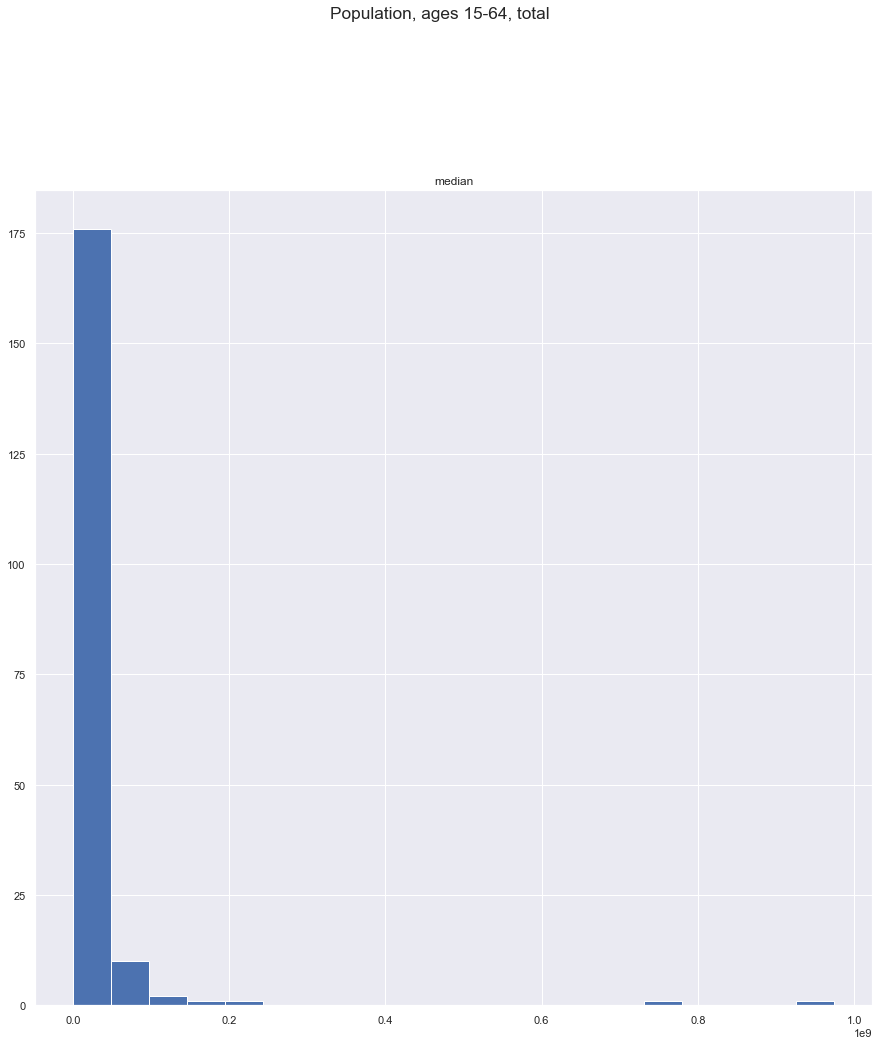

In [15]:
# On commence par dessiner un histogramme de notre cas
population_data.hist(bins=20, column='median', figsize=[15, 15])
plt.suptitle(population_indicator_name, x=0.5, y=1.05, ha='center', fontsize='xx-large')

Text(0.5, 1.05, 'Population, ages 15-64, total')

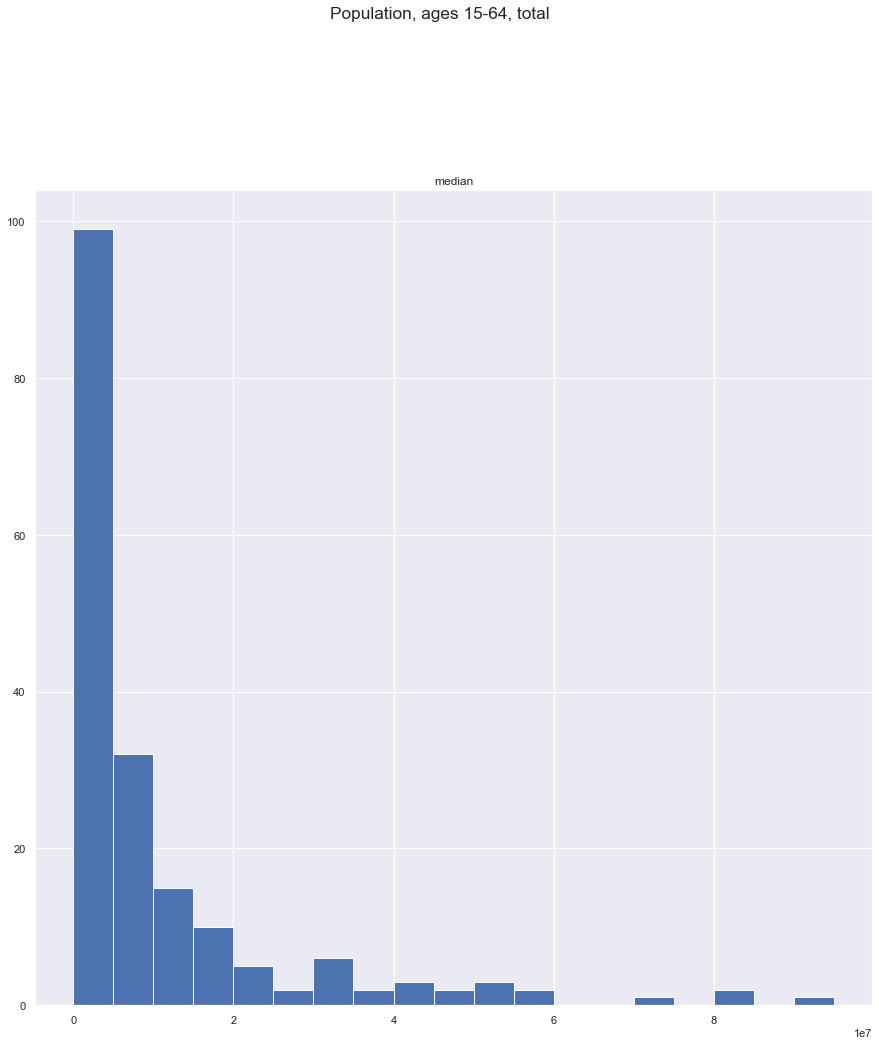

In [16]:
# les données sont très concentrées sur le premier bin, ie jusqu'à 100 millions, on va zoomer un peu plus 
bins_array = np.arange(0, 1e8, 5e6)
population_data.hist(bins=bins_array, column='median', figsize=[15, 15])
plt.suptitle(population_indicator_name, x=0.5, y=1.05, ha='center', fontsize='xx-large')

In [17]:
# Pour avoir une meilleure idée, comme EdTech est déjà installée en France, on va comparer ces données avec ce qui se passe
# en France
# On va commencer par récupérer la moyenne de la population en France (entre 15 et 64 ans)
population_in_france = population_data.where(population_data['Country Name'] == 'France')
population_in_france.dropna(how='all', inplace=True)
print(population_in_france['median'].iloc[0])

41796373.0


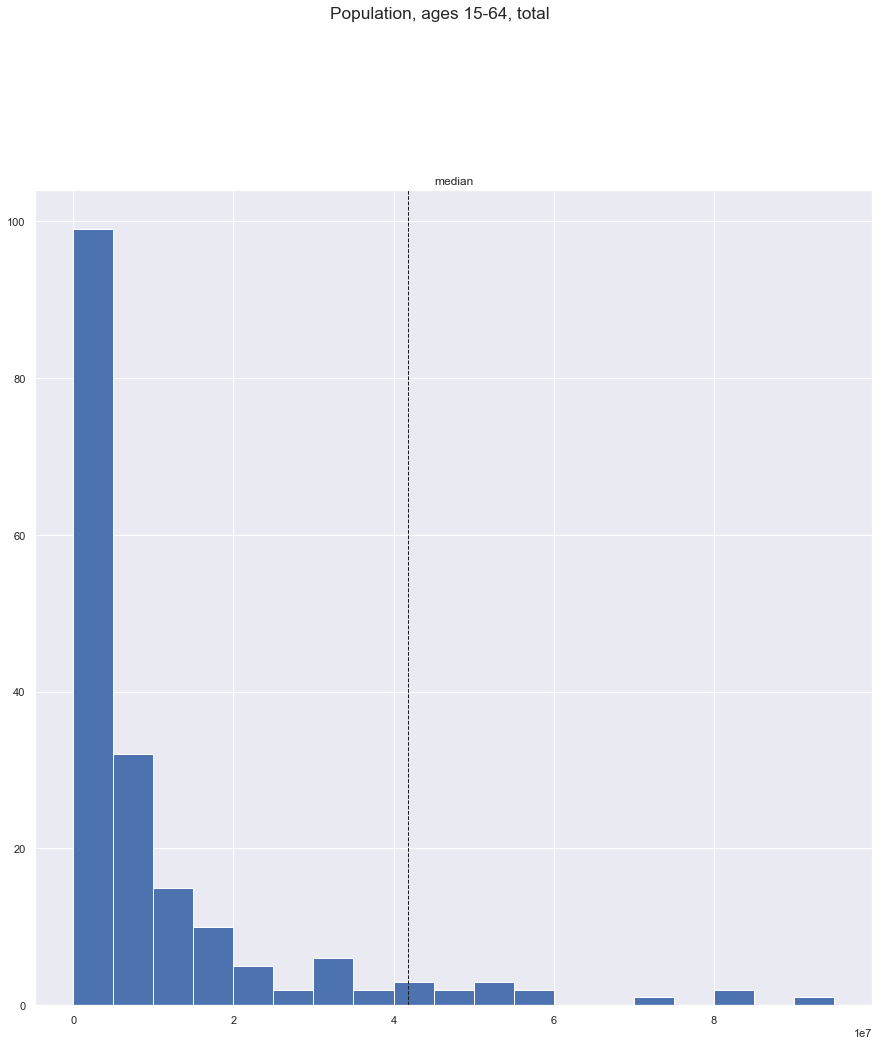

In [18]:
# puis on trace une ligne sur notre histogramme pour avoir une idée visuelle
population_data.hist(bins=bins_array, column='median', figsize=[15,15])
plt.suptitle(population_indicator_name, x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axvline(population_in_france['median'].iloc[0], color='k', linestyle='dashed', linewidth=1)

In [19]:
# Si EdTech veut reproduire le même Schéma qu'en France, l'une des clefs est le nombre d'utilisateurs
# on s'intéresse à une population assez nombreuse, comme d'autres criètres peuvent jouer, on va partir sur une population 
# supérieure à 10millions
population_data.where(population_data['median'] > 10000000, inplace=True) 
population_data.dropna(how='all', inplace=True)
population_data.describe(include='all')

,Country Name,median
count,61,6.100000e+01
unique,61,NaN
top,Sri Lanka,NaN
freq,1,NaN
mean,NaN,6.576627e+07
std,NaN,1.544610e+08
min,NaN,1.002807e+07
25%,NaN,1.515164e+07
50%,NaN,2.562434e+07
75%,NaN,5.093745e+07


In [20]:
# des 192 pays initiaux, on va s'intéresser aux 61 dont la population est la plus élevée 
# On peut donc rayer les autres pays de notre data frame intiale
edu_stats_data = pd.merge(edu_stats_data, population_data['Country Name'], how='inner', on='Country Name')
edu_stats_data.dropna(subset=year_columns_2000, how='all', inplace=True)
edu_stats_data.describe(include='all')

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2070,2075,2080,2085,2090,2095,2100,median,mean,std
count,113896,113896,113896,113896,5.616900e+04,3.599300e+04,3.639300e+04,4.003400e+04,3.916300e+04,5.886000e+04,...,16940.000000,16940.000000,16940.000000,16940.000000,16940.000000,16940.000000,16940.000000,1.138960e+05,1.138960e+05,1.138960e+05
unique,61,61,3453,3453,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Colombia,COL,"Population, ages 0-14 (% of total)",SE.PRM.ENRR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2444,2444,61,61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,4.362930e+09,6.976424e+09,7.137156e+09,6.888345e+09,7.609440e+09,5.398207e+09,...,961.913941,956.889823,949.270881,940.020167,929.288652,916.739012,902.365500,3.323217e+09,3.325387e+09,8.088803e+08
std,NaN,NaN,NaN,NaN,1.399267e+11,1.785332e+11,1.826205e+11,1.824431e+11,1.961586e+11,1.693236e+11,...,10263.663249,10378.561472,10463.687589,10524.903421,10558.794755,10557.416931,10521.753174,1.392226e+11,1.402316e+11,3.839229e+10
min,NaN,NaN,NaN,NaN,-6.759300e+04,-6.973700e+04,-9.214300e+04,-1.111860e+05,-1.262600e+05,-1.347240e+05,...,-0.390000,-0.330000,-0.260000,-0.200000,-0.140000,-0.110000,-0.080000,-4.765145e+05,-4.876937e+05,0.000000e+00
25%,NaN,NaN,NaN,NaN,5.081384e+00,1.580038e+01,1.574356e+01,1.489898e+01,1.327825e+01,5.040000e+00,...,0.020000,0.020000,0.010000,0.010000,0.010000,0.010000,0.010000,2.333922e+00,2.505000e+00,6.847262e-02
50%,NaN,NaN,NaN,NaN,4.504729e+01,1.397400e+04,1.440553e+04,4.447501e+02,6.845984e+02,4.381689e+01,...,0.280000,0.280000,0.290000,0.290000,0.290000,0.290000,0.280000,2.397099e+01,2.442622e+01,1.308292e+00
75%,NaN,NaN,NaN,NaN,3.217460e+05,1.220486e+06,1.214763e+06,9.675342e+05,1.041474e+06,2.968925e+05,...,11.000000,11.100000,11.200000,11.225000,11.200000,11.100000,11.000000,4.919893e+02,4.992159e+02,2.514356e+01


In [21]:
# la cible de EdTech sont les gens de niveau lycée / université, donc on va s'intéresser au nombre de diplômés médian pour 
# chacun des pays restants 
tertiary_education_data = get_median_per_country_for_indicator(tertiary_indicator_name, edu_stats_data, edu_country_series)
secondary_education_data = get_median_per_country_for_indicator(secondary_indicator_name, edu_stats_data, edu_country_series)
education_data = pd.DataFrame(index=tertiary_education_data.index, columns=tertiary_education_data.columns)
# On somme les données d'éducation pour avoir une seule data frame
education_data['Country Name'] = tertiary_education_data['Country Name']
education_data['median'] = tertiary_education_data ['median'] + secondary_education_data['median']

education_data.head()

,Country Name,median
0,Afghanistan,1665784.5
1,Algeria,4682458.5
2,Angola,694619.0
3,Argentina,6128039.0
4,Australia,3461043.0


In [22]:
education_data.describe(include='all')

,Country Name,median
count,61,6.000000e+01
unique,61,NaN
top,Sri Lanka,NaN
freq,1,NaN
mean,NaN,1.019481e+07
std,NaN,2.139725e+07
min,NaN,6.062280e+05
25%,NaN,2.530318e+06
50%,NaN,3.934303e+06
75%,NaN,8.298108e+06


Text(0.5, 1.05, 'Education data')

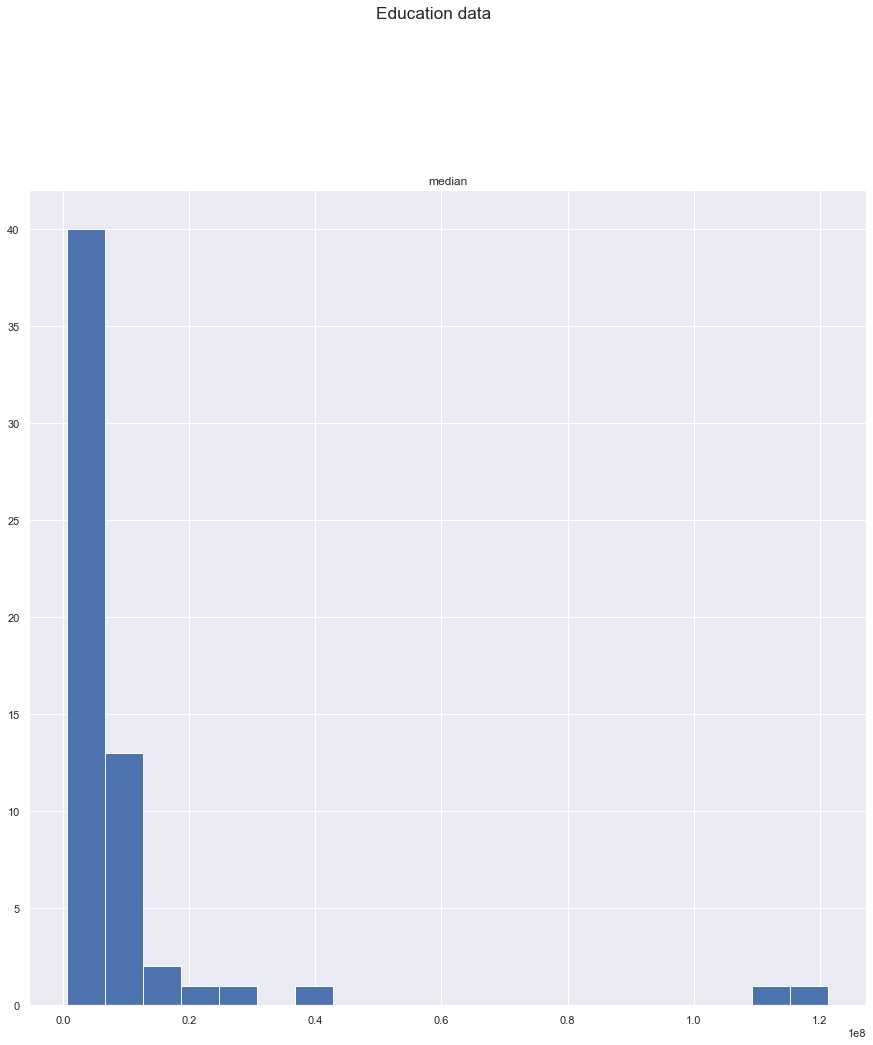

In [23]:
# Commençons par voir comment sont réparties les données
education_data.hist(bins=20, column='median', figsize=[15, 15])
plt.suptitle('Education data', x=0.5, y=1.05, ha='center', fontsize='xx-large')

In [24]:
# Comme ce qu'on a fait pour la population, on va utiliser la France comme benchmark
education_in_france = education_data.where(education_data['Country Name'] == 'France')
education_in_france.dropna(how='all', inplace=True)
print(education_in_france['median'].iloc[0])

8078803.0


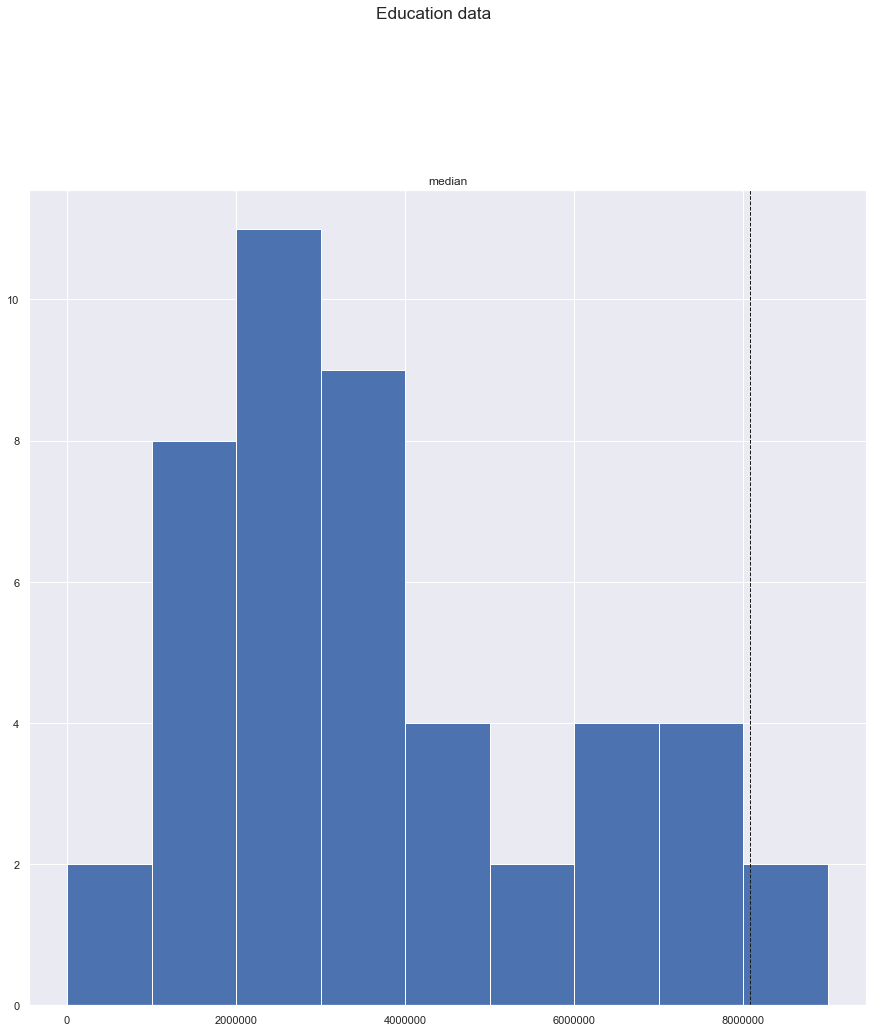

In [25]:
bins_array = np.arange(0, 1e7, 1e6)
education_data.hist(bins=bins_array, column='median', figsize=[15, 15])
plt.suptitle('Education data', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axvline(education_in_france['median'].iloc[0], color='k', linestyle='dashed', linewidth=1)

In [26]:
# La France est placée dans le percentile à 75% pour les données d'éducation, ce qui nous permet de rayer d'autres
# pays qui vont pas correspondre au besoin, toujours pour voir comment jouent les autres paramètres, on va juste 
# se limiter aux pays dont la médiane sur les lycées / universitaires durant ces dernières années dépasse les 6 millions
education_data.where(education_data['median'] > 6000000, inplace=True) 
education_data.dropna(how='all', inplace=True)
education_data.describe(include='all')

,Country Name,median
count,24,2.400000e+01
unique,24,NaN
top,"Egypt, Arab Rep.",NaN
freq,1,NaN
mean,NaN,2.125710e+07
std,NaN,3.097070e+07
min,NaN,6.031662e+06
25%,NaN,7.607086e+06
50%,NaN,1.052873e+07
75%,NaN,1.484884e+07


In [27]:
# ce qui nous ramène à 23 pays, on raye ses pays de notre dataframe originale
edu_stats_data = pd.merge(edu_stats_data, education_data['Country Name'], how='inner', on='Country Name')
edu_stats_data.dropna(subset=year_columns_2000, how='all', inplace=True)
edu_stats_data.head(30)

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2070,2075,2080,2085,2090,2095,2100,median,mean,std
0,Argentina,ARG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,82.509750,82.596741,81.979988,81.841118,81.417267,81.559692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.914383,82.539008,1.813480
1,Argentina,ARG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,83.864563,84.090279,83.228058,83.400078,83.525253,83.907806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.886185,84.420089,1.415977
2,Argentina,ARG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,1.032910,1.036300,1.030460,1.038240,1.052290,1.058270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.045885,1.046069,0.015215
3,Argentina,ARG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,81.192902,81.144958,80.767540,80.328323,79.374527,79.287369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.547932,80.753776,2.269103
4,Argentina,ARG,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,99.548470,NaN,NaN,99.542976,99.197281,99.345833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.435509,99.386211,0.174353
5,Argentina,ARG,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,NaN,NaN,NaN,99.314484,98.597603,98.885139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.011524,98.943454,0.349276
6,Argentina,ARG,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,NaN,NaN,NaN,0.995490,0.988180,0.990920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990920,0.991087,0.003392
7,Argentina,ARG,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,NaN,NaN,NaN,99.764008,99.777260,99.791420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.782654,99.784877,0.046597
8,Argentina,ARG,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3,55.579769,58.525440,59.392860,59.620560,57.956928,56.748550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.959024,57.941647,1.716273
9,Argentina,ARG,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3.F,58.737679,61.735668,62.761108,62.368832,60.935120,61.259560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.918995,62.534756,1.937476


In [28]:
# EdTech veut mettre du contenu en ligne, il serait logique de regarder le nombre d'utilisateurs internet par pays
# On a un indicateur qui donnée le nombre en pourcent, on a juste besoin de le convertir en nombre de personnes en utilisant 
# la population entre 15 et 64 ans
# on récupère les données population et internet
internet_data = get_median_per_country_for_indicator(internet_indicator_name, edu_stats_data, edu_country_series)
population_data = get_median_per_country_for_indicator(population_indicator_name, edu_stats_data, edu_country_series)

# on mulitplie les deux en prenant soin de diviser par 100
internet_total_data = pd.DataFrame(index=internet_data.index, columns=population_data.columns)
internet_total_data['Country Name'] = internet_data['Country Name'] 
internet_total_data['median'] = internet_data['median'] * population_data['median'] / 100
internet_total_data.describe(include='all')

,Country Name,median
count,24,2.400000e+01
unique,24,NaN
top,"Egypt, Arab Rep.",NaN
freq,1,NaN
mean,NaN,3.280239e+07
std,NaN,4.986645e+07
min,NaN,2.320871e+06
25%,NaN,7.145676e+06
50%,NaN,1.576049e+07
75%,NaN,3.230795e+07


In [29]:
# Encore une fois, on utilise l'expérience d'EdTech en France
internet_in_france = internet_total_data.where(internet_total_data['Country Name'] == 'France')
internet_in_france.dropna(how='all', inplace=True)
print(internet_in_france['median'].iloc[0])

29541676.436400004


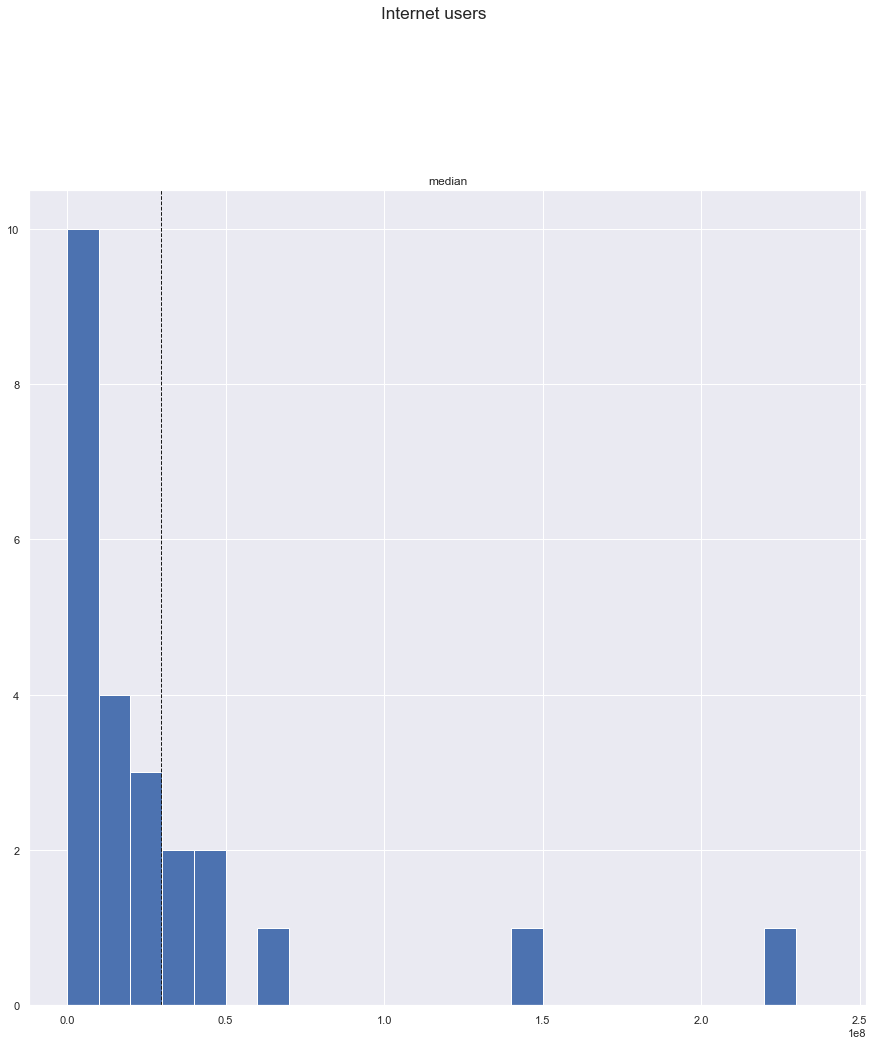

In [30]:
# On dessine à nouveau ça sur un histogramme
bins_array = np.arange(0, 2.5e8 , 1e7)
internet_total_data.hist(bins=bins_array, column='median', figsize=[15, 15])
plt.suptitle('Internet users', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axvline(internet_in_france['median'].iloc[0], color='k', linestyle='dashed', linewidth=1)

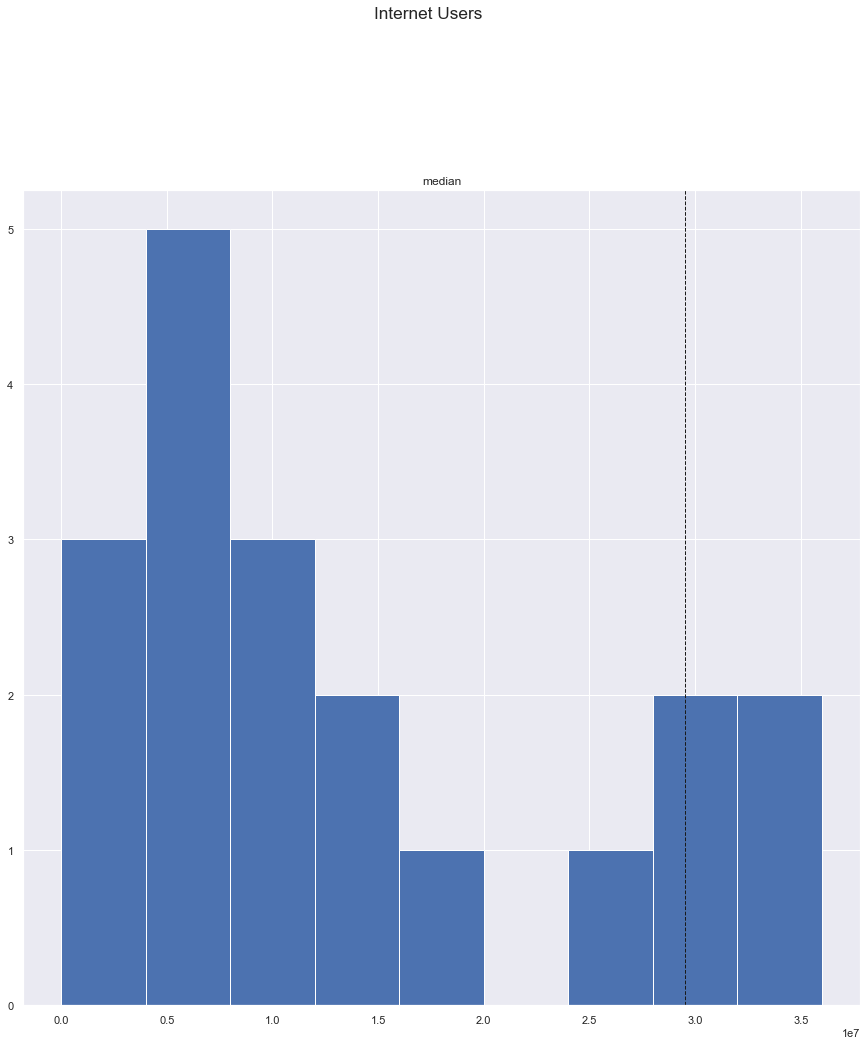

In [31]:
# On va zommer un peu plus autour de la France
bins_array = np.arange(0, 4e7 , 4e6)
internet_total_data.hist(bins=bins_array, column='median', figsize=[15, 15])
plt.suptitle('Internet Users', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axvline(internet_in_france['median'].iloc[0], color='k', linestyle='dashed', linewidth=1)

In [32]:
# La France compte plus que 25 millions d'utilisateurs internet, on va rayer les pays de moins de 20 millions d'utilisateurs internet
internet_total_data.where(internet_total_data['median'] > 2e7, inplace=True) 
internet_total_data.dropna(how='all', inplace=True)
internet_total_data.describe(include='all')

,Country Name,median
count,10,1.000000e+01
unique,10,NaN
top,India,NaN
freq,1,NaN
mean,NaN,6.652366e+07
std,NaN,6.447252e+07
min,NaN,2.728507e+07
25%,NaN,3.015885e+07
50%,NaN,3.778528e+07
75%,NaN,5.830525e+07


In [33]:
internet_total_data.head(10)

,Country Name,median
2,Brazil,4.420826e+07
3,China,2.202093e+08
6,France,2.954168e+07
7,Germany,4.236987e+07
8,India,3.320068e+07
12,Japan,6.300424e+07
13,"Korea, Rep.",2.893713e+07
18,Russian Federation,2.728507e+07
22,United Kingdom,3.201038e+07
23,United States,1.444700e+08


In [34]:
# Il ne reste plus qu'à cleaner la data frame originale des pays qu'on ne retient pas 
edu_stats_data = pd.merge(edu_stats_data, internet_total_data['Country Name'], how='inner', on='Country Name')
edu_stats_data.dropna(subset=year_columns_2000, how='all', inplace=True)
edu_stats_data.describe(include='all')

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2070,2075,2080,2085,2090,2095,2100,median,mean,std
count,18412,18412,18412,18412,9.903000e+03,6.127000e+03,6.229000e+03,7.148000e+03,6.287000e+03,9.910000e+03,...,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,1.841200e+04,1.841200e+04,1.841200e+04
unique,10,10,2619,2619,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"Korea, Rep.",KOR,Pupil-teacher ratio in tertiary education (hea...,SP.POP.TOTL.FE.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1978,1978,10,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.736406e+10,2.875491e+10,2.929221e+10,2.704303e+10,3.303502e+10,2.226908e+10,...,2617.043049,2566.840981,2511.942510,2454.735468,2396.099494,2335.111617,2271.381097,1.418218e+10,1.425820e+10,3.419609e+09
std,NaN,NaN,NaN,NaN,3.248141e+11,4.214746e+11,4.299085e+11,4.203652e+11,4.762918e+11,4.017130e+11,...,22452.140583,22597.630832,22673.225778,22692.859000,22649.545835,22524.478812,22320.031249,3.370580e+11,3.398698e+11,9.365643e+10
min,NaN,NaN,NaN,NaN,-6.759300e+04,-6.973700e+04,-9.214300e+04,-1.111860e+05,-1.262600e+05,-1.347240e+05,...,-0.160000,-0.140000,-0.130000,-0.120000,-0.100000,-0.080000,-0.060000,-4.765145e+05,-4.876937e+05,0.000000e+00
25%,NaN,NaN,NaN,NaN,5.960000e+00,2.056645e+01,1.782496e+01,1.674442e+01,1.672344e+01,5.692838e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000e+00,2.521643e+00,5.883351e-02
50%,NaN,NaN,NaN,NaN,4.848682e+01,2.153026e+04,1.246000e+04,4.769860e+02,8.017243e+03,4.310388e+01,...,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.250000,2.440894e+01,2.498125e+01,1.032562e+00
75%,NaN,NaN,NaN,NaN,5.131615e+05,2.735564e+06,2.557181e+06,1.997307e+06,2.377130e+06,4.720598e+05,...,11.025000,11.225000,11.400000,11.510000,11.300000,11.347500,11.500000,9.799975e+02,1.131497e+03,6.402258e+01


In [35]:
# Comme on est tombé à 10 pays seulement, on aimerait pouvoir les classer et voir ceux qui correspondent le mieux à notre besoin
# Si EdTech vend du contenu aux utilisateurs, il faut qu'on vérifie leur pouvoir d'achat, et le PIB semble être un bon indicateur
# pour ça, comme on veut pouvoir comparer les courbes de l'évolution de ce pouvoir d'achat on est obligé de transposer les données 

# on récupère pour le PIB, la population, et le pourcent d'utilisateurs internet une dataframe avec pour index le pays 
# et pour colonne l'année après 2000
gdp_data = get_transposed_filtered_data(gdp_indicator_name, edu_stats_data)
internet_data = get_transposed_filtered_data(internet_indicator_name, edu_stats_data)
population_data = get_transposed_filtered_data(population_indicator_name, edu_stats_data)

# on estime le nombre d'utilisateurs potentiels de la plateforme à population * internet users / 100, suffit de multiplier par 
# le PIB par habitant pour avoir le PIB total sur les utilisateurs
population_users_data = population_data.mul(internet_data)
population_users_data = population_users_data.divide(100)
total_gdp_for_users_data = population_users_data.mul(gdp_data)
total_gdp_for_users_data.head()

,Brazil,China,France,Germany,India,Japan,"Korea, Rep.",Russian Federation,United Kingdom,United States
2000,2.93946e+10,4.50313e+10,1.48866e+11,4.59715e+11,6.68686e+09,6.95505e+11,2.74339e+11,1.37128e+10,2.69611e+11,2.92328e+12
2001,4.83489e+10,7.48203e+10,2.91339e+11,5.02978e+11,9.01171e+09,9.14245e+11,3.7228e+11,2.20421e+10,3.55062e+11,3.4499e+12
2002,1.02799e+11,1.46055e+11,3.4796e+11,7.95774e+11,2.22364e+10,1.13047e+12,4.25522e+11,3.36695e+10,6.31834e+11,4.28043e+12
2003,1.53963e+11,2.24113e+11,4.1398e+11,9.2903e+11,2.6968e+10,1.20151e+12,4.84624e+11,7.80088e+10,7.62177e+11,4.72071e+12
2004,2.42969e+11,3.02242e+11,4.66362e+11,1.12385e+12,3.52316e+10,1.62089e+12,5.79421e+11,1.33802e+11,8.22209e+11,5.29689e+12


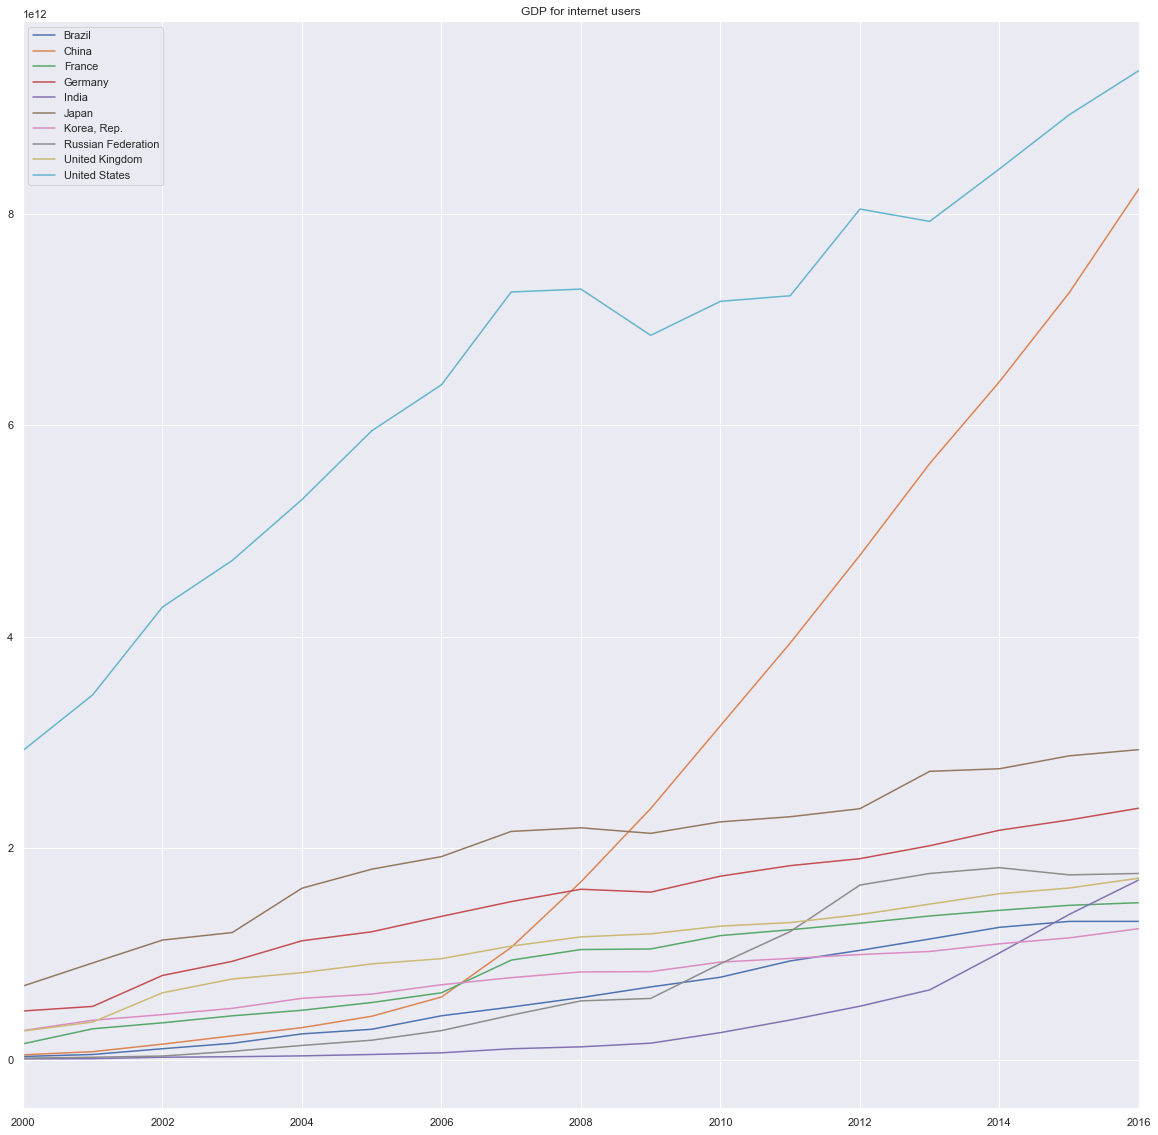

In [36]:
# On graphe ça 
total_gdp_for_users_data.plot(title='GDP for internet users', figsize=[20, 20])

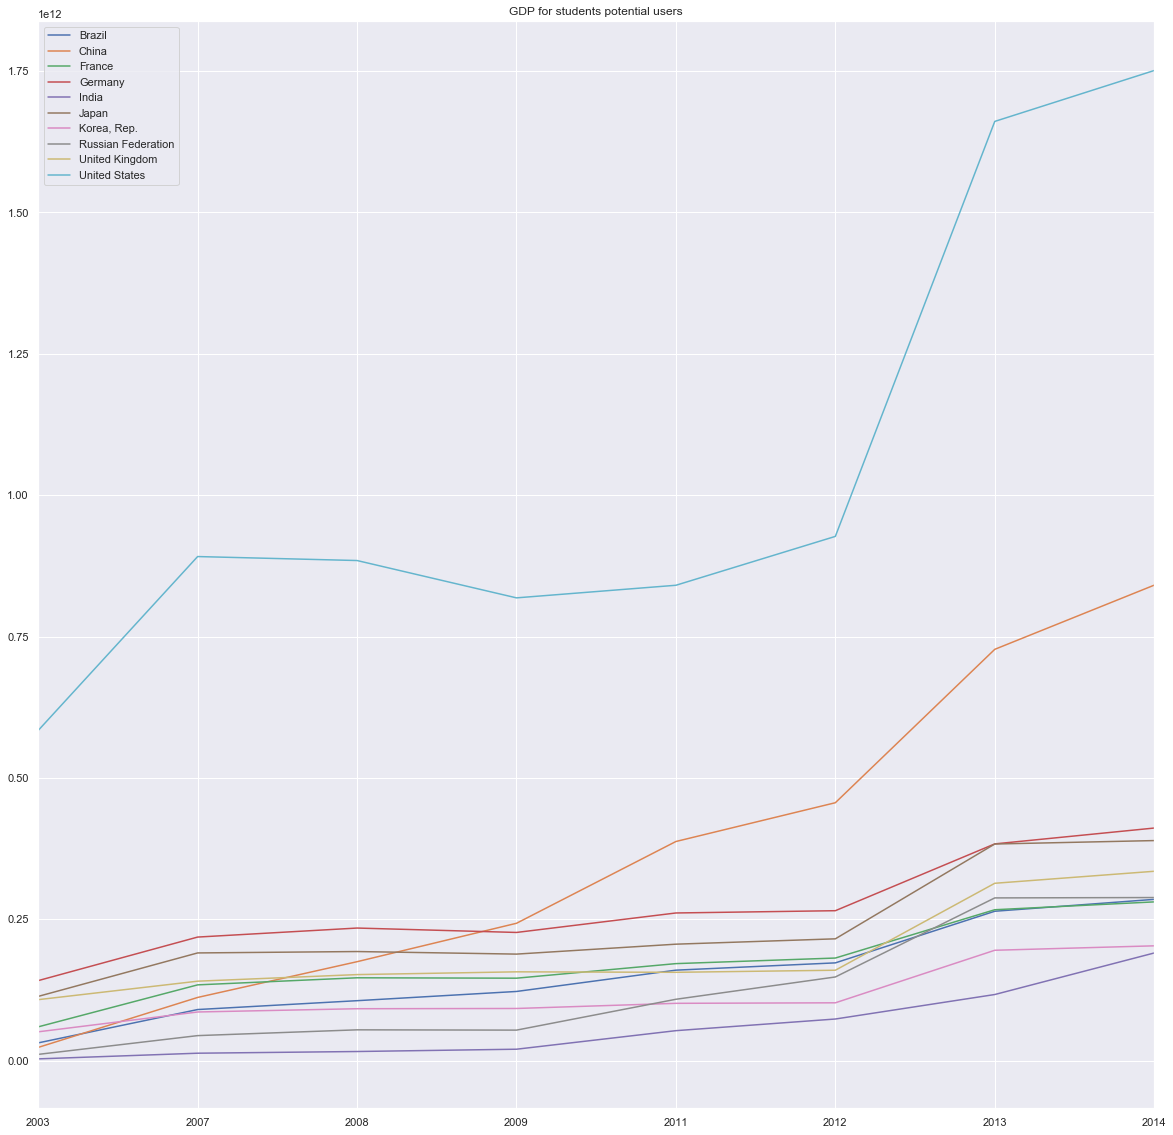

In [37]:
# En terme d'évolution, la chine et les USA sont les plus intéressants, et en comparaison par rapport à la france 
# on pourrait rajouter l'Allemagne, le Japon, la Russie, l'Inde, et les UKs
# Mais je pense que notre indicateur n'est pas fiable, ce serait plus juste d'utiliser les étudiants par années qui utilisent 
# internet plus que la population totale

# On refait pareil qu'au dessus, sauf qu'on prend les étudiants inscrits au lycée / université au lieu de toute la population
tertiary_edu_data = get_transposed_filtered_data(tertiary_indicator_name, edu_stats_data)
secondary_edu_data = get_transposed_filtered_data(secondary_indicator_name, edu_stats_data)
education_data = tertiary_edu_data.add(secondary_edu_data, fill_value=0)

new_potential_users_data = education_data.mul(internet_data)
new_potential_users_data = new_potential_users_data.divide(100)
total_gdp_for_students_data = new_potential_users_data.mul(gdp_data)
total_gdp_for_students_data.dropna(how='all', inplace=True)
total_gdp_for_students_data.plot(title='GDP for students potential users', figsize=[20, 20])

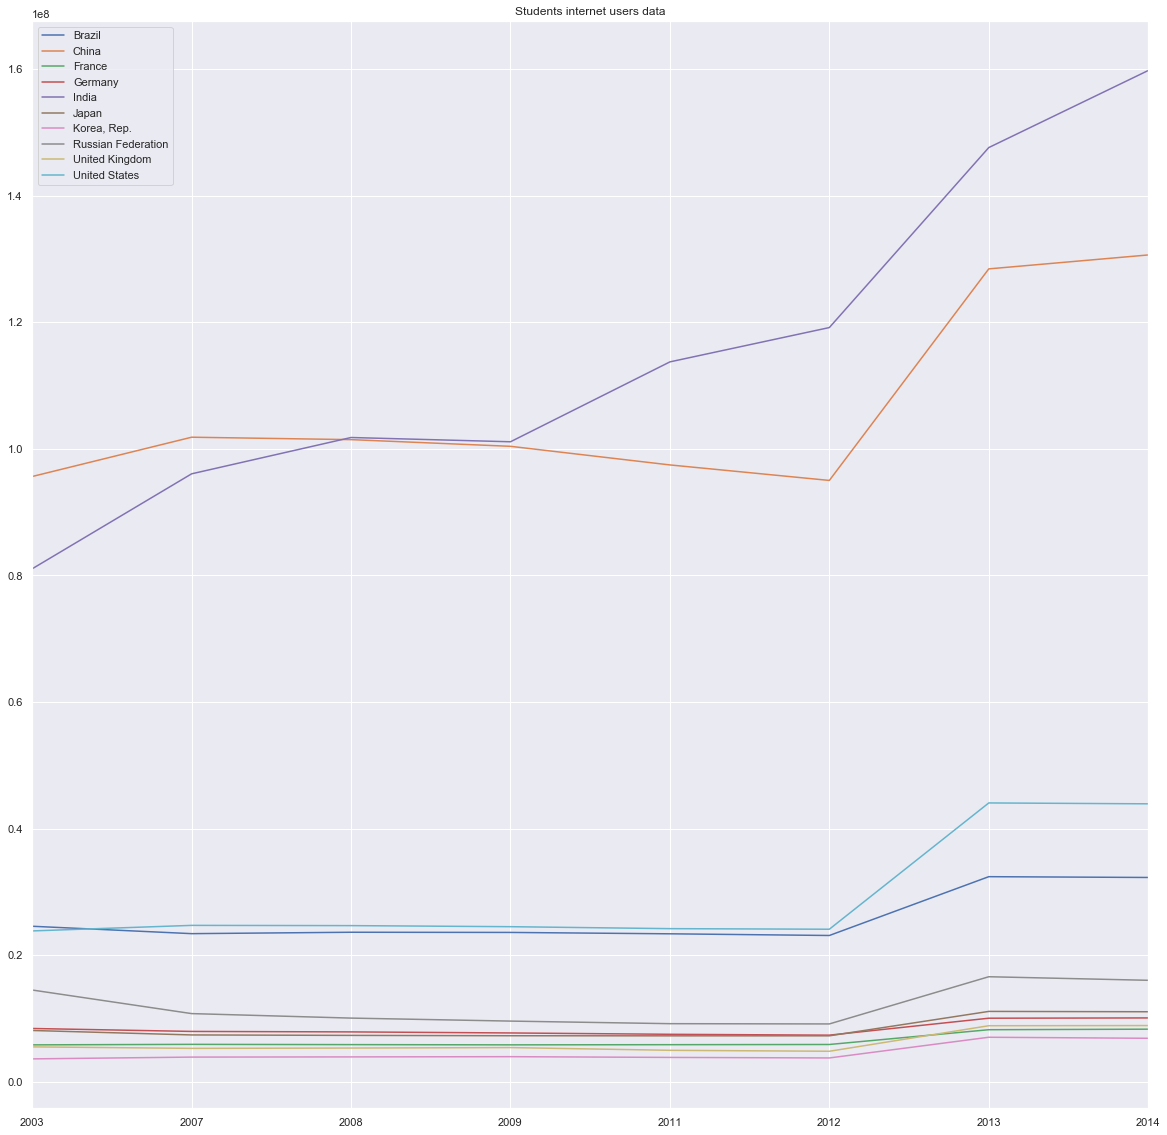

In [38]:
# On se retrouve avec les USA, la Chine, le Japon, et la Russie et les UKs comme pays les plys intéressants
# En terme d'utilisateurs actuels, et de potentiel futur, les USA prennent largement la tête

# si on regarde juste les étudiants, utilisateurs d'internet qui nous intéressent
education_data.plot(title='Students internet users data', figsize=[20, 20])

In [39]:
# On voit que la Chine est l'Inde sont largement supérieurs, ils seraient intéressants comme candidats si la plateforme 
# ne prévoyait pas de vendre du contenu